In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 1

In [146]:
x=np.linspace(-5,5,1000)
y_true=4.0*x**3+10*x**2-3*x+8

noise = 1
Ninv=1.0/noise**2

y=y_true+noise*np.random.randn(len(x))

def generate_a(order):
    a=np.zeros([len(x),order+1])
    a[:,0]=1.0
    for i in range(order):
        a[:,i+1]=a[:,i]*x
    return a

This is what our data looks like with noise

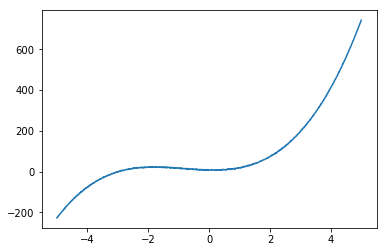

In [147]:
plt.plot(x,y)

Let's first generate our A matrix using order 5

In [148]:
a = generate_a(5)

Least squares fit using SVD factorization

In [149]:
u,s,v=np.linalg.svd(a,0)
utd=np.dot(u.transpose(),y)
sutd=utd/s
fitp=np.dot(v.transpose(),sutd)
y_pred=np.dot(a,fitp)

Least squares fit using QR factorization

In [150]:
u2,v2 = np.linalg.qr(a)
utd2=np.dot(u2.transpose(),y)
fitp2=np.dot(np.linalg.inv(v2),utd2)
y_pred2=np.dot(a,fitp2)

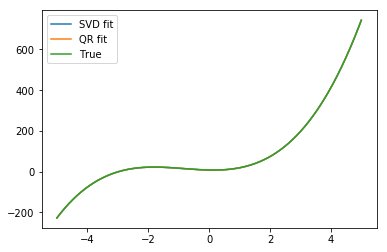

In [151]:
plt.plot(x,y_pred,label='SVD fit')
plt.plot(x,y_pred2,label='QR fit')
plt.plot(x,y_true,label='True')
plt.legend()

Both methods work pretty well. What is we used higher-order polynomials? Take order 20:

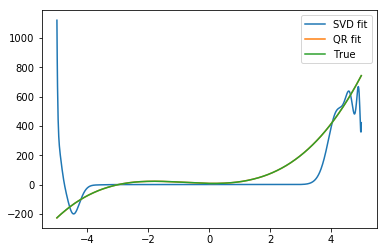

In [152]:
a = generate_a(50)

u,s,v=np.linalg.svd(a,0)
utd=np.dot(u.transpose(),y)
sutd=utd/s
fitp=np.dot(v.transpose(),sutd)
y_pred=np.dot(a,fitp)

u2,v2 = np.linalg.qr(a)
utd2=np.dot(u2.transpose(),y)
fitp2=np.dot(np.linalg.inv(v2),utd2)
y_pred2=np.dot(a,fitp2)

plt.plot(x,y_pred,label='SVD fit')
plt.plot(x,y_pred2,label='QR fit')
plt.plot(x,y_true,label='True')
plt.legend()

As we see, the QR method behaves better at higher orders, while the SVD method does not

### Problem 2

First let's generate out Chebyshev polynomials to large order (100)

In [158]:
x=np.linspace(-1,1,10001)

def generate_p(order):
    p=np.zeros([len(x),ord+1])
    p[:,0]=1.0
    p[:,1]=x
    for n in range(1,ord):
        tmp=2*x*p[:,n]-p[:,n-1]
        p[:,n+1]=tmp
    return p


p = generate_p(100)

In [159]:
y = np.exp(x) 

The fit is stable:

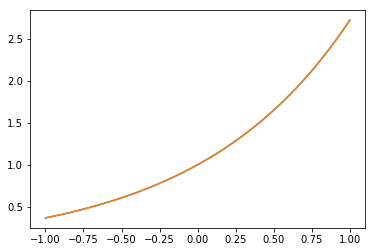

In [160]:
def fit_chebs(p,y):
    lhs=np.dot(p.transpose(),p)
    rhs=np.dot(p.transpose(),y)

    lhs_inv=np.linalg.inv(lhs)
    fitp=np.dot(lhs_inv,rhs)
    pred=np.dot(p,fitp)
    
    return pred

pred = fit_chebs(p,y)
rms=np.std(pred-y)
    
plt.plot(x,pred)
plt.plot(x,y)

Now let's fit with order 6 and calculate the rms and maximum error of this fit:

In [157]:
p = generate_p(6)

pred = fit_chebs(p,y)
rms=np.std(pred-y)
max_error = max(pred-y)

rms, max_error

(19088424.621310368, 142675.76057963399)

Now let's fit with order 100, truncate to 6 terms, and do the same:

In [139]:
p = generate_p(10000)

lhs=np.dot(p.transpose(),p)
rhs=np.dot(p.transpose(),y)

lhs_inv=np.linalg.inv(lhs)
fitp=np.dot(lhs_inv,rhs)
pred=np.dot(p[:,:7],fitp[:7])

rms_trunc=np.std(pred-y)
max_error_trunc = max(pred-y)

rms_trunc, max_error_trunc

(2.2576897549773781e-06, 3.3866948263572283e-06)

In [140]:
(rms-rms_trunc)/rms, max_error/max_error_trunc

(-977631624.34543121, 1.1670357591436137e-08)

### Problem 3

Let's generate the noise matrix and do its eigendecomposition

In [52]:
x=np.linspace(-1,1,10001)

dim = 100

N=np.zeros((dim,dim))

for col in range(dim):
    for row in range(dim):
        if col == row:
            N[col,row]=2
        else:
            N[col,row]=1

eigval, eigvec = np.linalg.eigh(N)

In [55]:
M = np.diag(eigval)
N = (M)**0.5
S = eigvec

calculate the transformation matrix with which we will rotate our random data:

In [57]:
T = np.dot(S,N)

Do this over many (1000) iterations:

In [73]:
num = 1000
Ds = np.zeros((num,dim,dim))
for i in range(num):
    D = np.random.randn(dim)
    Ds[i] = np.outer(np.dot(T,D),np.dot(T,D).transpose())

Find the average:

In [74]:
np.mean(Ds,axis=0)

array([[ 1.9086356 ,  0.94091254,  0.89201454, ...,  0.93170365,
         0.92933913,  0.9924902 ],
       [ 0.94091254,  1.96340294,  0.94944858, ...,  0.92540115,
         0.9472702 ,  0.95528534],
       [ 0.89201454,  0.94944858,  1.91025762, ...,  0.8693207 ,
         0.89702162,  0.98587786],
       ..., 
       [ 0.93170365,  0.92540115,  0.8693207 , ...,  1.90275297,
         0.95495095,  1.00077498],
       [ 0.92933913,  0.9472702 ,  0.89702162, ...,  0.95495095,
         1.97531292,  0.99016279],
       [ 0.9924902 ,  0.95528534,  0.98587786, ...,  1.00077498,
         0.99016279,  2.02865201]])

As you can see, this looks like the noise matrix we started with

### Problem 4

Assume we have a Gaussian signal:

In [141]:
dx=1

x=np.arange(0,1000,dx)
n=len(x)

x0=500
amp_true=1

sig=50
template=np.exp(-0.5*(x-x0)**2/sig**2)

We initiliaze the required noise matrix and the parameters we will use to vary it:

In [155]:
a_corr = [0.1,0.5,0.9]
sig_corr = [5,50,500]

N=np.zeros((n,n))

And calculate the error on the fit amplitude for each pair of values: 

In [63]:
for a in [0,1,2]:
    for b in [0,1,2]:

        for i in range(n):
            for j in range(n):
                if i==j:
                    N[i,j]=1
                else:
                    N[i,j] = a_corr[a]*np.exp(-((i-j)**2)/(2*sig_corr[b]**2))

        Ninv = np.linalg.inv(N)
        denom=(np.dot(template,np.dot(Ninv,template)))
        rt_denom=np.sqrt(denom)

        error=1/rt_denom

        print ("a = ", a_corr[a], ", sigma = ",  sig_corr[b], ", best-fit error = ", error)

a =  0.1 , sigma =  5 , best-fit error =  0.155763354876
a =  0.1 , sigma =  50 , best-fit error =  0.337744895623
a =  0.1 , sigma =  500 , best-fit error =  0.12757498759
a =  0.5 , sigma =  5 , best-fit error =  0.275999350803
a =  0.5 , sigma =  50 , best-fit error =  0.714054477056
a =  0.5 , sigma =  500 , best-fit error =  0.100663921407
a =  0.9 , sigma =  5 , best-fit error =  0.357895259964
a =  0.9 , sigma =  50 , best-fit error =  0.949931946858
a =  0.9 , sigma =  500 , best-fit error =  0.0489254946682


a =  0.9 , sigma =  50 has the worst and
a =  0.9 , sigma =  500 has the best